### LIBRARIES

In [ ]:
# !pip install gymnasium
# !pip install numpy
# !pip install torch
# !pip install keras

In [1]:
import gymnasium as gym
import numpy as np
import random as rand
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import load_model
from collections import deque
import matplotlib.pyplot as plt

2024-09-27 22:43:43.243738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-27 22:43:43.269794: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-27 22:43:43.276234: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-27 22:43:43.297644: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 22:43:44.913620: W tensorflow/compiler/tf2

In [2]:
import tensorflow as tf

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


I0000 00:00:1727477029.137525      21 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727477029.421916      21 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727477029.422001      21 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


### HYPERPARAMETERS

In [3]:
# Hyperparameters
GAMMA = 0.99  # Discount factor

NUM_EPISODES = 500  # Number of episodes to run

BATCH_SIZE = 64  # Number of experiences to sample per training step
MEMORY_SIZE = 10000  # Experience replay memory size

LEARNING_RATE = 0.001  # Learning rate
EPSILON = 1.0  # Initial exploration rate
EPSILON_DECAY = 0.995  # Exploration decay rate per episode
MIN_EPSILON = 0.01  # Minimum exploration rate

MAX_ITERATIONS = 500  # Max steps per episode
TARGET_UPDATE_FREQUENCY = 10  # Episodes between target network updates

### MEMORY

In [4]:
class Memory:
    """
    Experience Replay Memory.
    
    Args:
        max_memory (int): Maximum number of experiences the Memory can keep.
    """
    def __init__(self, max_memory):
        self._samples = deque(maxlen=max_memory)

    def add_sample(self, sample):
        self._samples.append(sample)

    def sample(self, num_samples):
        num_samples = min(num_samples, len(self._samples))
        return rand.sample(self._samples, num_samples)

    @property
    def num_samples(self):
        return len(self._samples)

### DEEP Q-LEARNING AGENT

In [5]:
class DQLAgent:
    """
    Deep Q-Learning Agent.
    """
    def __init__(self, state_size, action_size):
        
        self.state_size = state_size
        self.action_size = action_size

        self.gamma = GAMMA
        self.epsilon = EPSILON
        self.epsilon_min = MIN_EPSILON
        self.epsilon_decay = EPSILON_DECAY
        self.learning_rate = LEARNING_RATE
        self.batch_size = BATCH_SIZE

        self.memory = Memory(MEMORY_SIZE)

        # Main model (Q-network) and target model (target Q-network)
        self.main_model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        """
        Creates a neural network model.
        
        Returns:
            keras.models.Sequential: Neural network model.
        """
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        """
        Updates the target Q-network with the weights of the main Q-network.
        """
        self.target_model.set_weights(self.main_model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """
        Stores an experience in the replay memory.
        """
        self.memory.add_sample((state, action, reward, next_state, done))

    def act(self, state):
        """
        Selects an action using the epsilon-greedy policy.
        
        Args:
            state (array): Current state.
            
        Returns:
            int: Selected action.
        """
        if np.random.rand() <= self.epsilon:
            return rand.randrange(self.action_size)
        q_values = self.main_model.predict(np.array([state]), verbose=0)
        return np.argmax(q_values[0])

    def replay(self):
        """
        Trains the Q-network using a batch of experiences from the replay memory.
        """
        if self.memory.num_samples < self.batch_size:
            return

        batch = self.memory.sample(self.batch_size)
        states = np.array([sample[0] for sample in batch])
        actions = np.array([sample[1] for sample in batch])
        rewards = np.array([sample[2] for sample in batch])
        next_states = np.array([sample[3] for sample in batch])
        dones = np.array([sample[4] for sample in batch])
        
        # Target Q-values prediction
        next_qs = self.target_model.predict(next_states, verbose=0)
        max_next_qs = np.max(next_qs, axis=1)
        target_qs = rewards + (1 - dones) * self.gamma * max_next_qs

        # Actual Q-values prediction
        current_qs = self.main_model.predict(states, verbose=0)
        for i, action in enumerate(actions):
            current_qs[i][action] = target_qs[i]

        # Q-network training
        self.main_model.fit(states, current_qs, epochs=1, verbose=0)

    def load(self, name):
        """
        Loads a model from a file.
        
        Args:
            name (str): Name of the file.
        """
        self.main_model = load_model(name)
        self.target_model = load_model(name)

    def save(self, name):
        """
        Saves the model to a file.
        
        Args:
            name (str): Name of the file.
        """
        self.main_model.save(name)

In [6]:
def train_agent(env, agent):
    """
    Trains the agent using Deep Q-Learning.
    
    Args:
        env (gym.Env): Environment.
        agent (DQLAgent): Agent.
        
    Returns:
        DQLAgent: Trained agent.
    """
    episode_rewards = []

    for episode in range(NUM_EPISODES):
        state, _ = env.reset()
        total_reward = 0

        for t in range(MAX_ITERATIONS):
            # Render environment
            # env.render()

            # Action selection
            action = agent.act(state)

            # Environment interaction
            next_state, reward, done, truncated, _ = env.step(action)
            total_reward += reward

            # Store experience in replay memory
            agent.remember(state, action, reward, next_state, done)
            state = next_state

            # Experience replay
            agent.replay()

            if done or truncated:
                print(f"Episodio {episode + 1}/{NUM_EPISODES}, Recompensa Total: {total_reward}, Epsilon: {agent.epsilon:.2f}")
                break

        episode_rewards.append(total_reward)
        
        # Target model update
        if (episode + 1) % TARGET_UPDATE_FREQUENCY == 0:
            agent.update_target_model()

        # Exploration rate decay
        if agent.epsilon > agent.epsilon_min:
            agent.epsilon *= agent.epsilon_decay
    
    # Graph total rewards per episode
    plt.plot(range(1, NUM_EPISODES + 1), episode_rewards, marker='o')
    plt.title('Recompensa Total por Episodio')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa Total')
    plt.xticks(range(1, NUM_EPISODES + 1))
    y_max = max(episode_rewards) * 1.1
    plt.ylim(0, y_max)
    plt.show()

def test_agent(env, agent, episodes=5):
    """
    Tests the agent in the environment.
    
    Args:
        env (gym.Env): Environment.
        agent (DQLAgent): Agent.
        episodes (int): Number of episodes to run.
    """
    total_rewards = []
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            env.render()
            q_values = agent.main_model.predict(np.array([state]), verbose=0)
            action = np.argmax(q_values[0])
            state, reward, done, truncated, _ = env.step(action)
            total_reward += reward
            if done or truncated:
                total_rewards.append(total_reward)
                print(f"Prueba Episodio {episode + 1}/{episodes}, Recompensa Total: {total_reward}")
                break
    avg_reward = np.mean(total_rewards)
    print(f"Recompensa promedio en {episodes} pruebas: {avg_reward}")
    env.close()


/usr/local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1727477050.077352      21 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727477050.077567      21 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727477050.077608      21 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727477050.975225      21 cuda_executor.cc:1001] could not open

Episodio 1/500, Recompensa Total: 19.0, Epsilon: 1.00
Episodio 2/500, Recompensa Total: 17.0, Epsilon: 0.99
Episodio 3/500, Recompensa Total: 11.0, Epsilon: 0.99


I0000 00:00:1727477053.023176     103 service.cc:146] XLA service 0x7fb5400042a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727477053.023228     103 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2024-09-27 22:44:13.031713: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-27 22:44:13.104476: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1727477053.322045     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Episodio 4/500, Recompensa Total: 34.0, Epsilon: 0.99
Episodio 5/500, Recompensa Total: 29.0, Epsilon: 0.98
Episodio 6/500, Recompensa Total: 27.0, Epsilon: 0.98
Episodio 7/500, Recompensa Total: 27.0, Epsilon: 0.97
Episodio 8/500, Recompensa Total: 16.0, Epsilon: 0.97
Episodio 9/500, Recompensa Total: 25.0, Epsilon: 0.96
Episodio 10/500, Recompensa Total: 24.0, Epsilon: 0.96
Episodio 11/500, Recompensa Total: 20.0, Epsilon: 0.95
Episodio 12/500, Recompensa Total: 21.0, Epsilon: 0.95
Episodio 13/500, Recompensa Total: 18.0, Epsilon: 0.94
Episodio 14/500, Recompensa Total: 19.0, Epsilon: 0.94
Episodio 15/500, Recompensa Total: 24.0, Epsilon: 0.93
Episodio 16/500, Recompensa Total: 29.0, Epsilon: 0.93
Episodio 17/500, Recompensa Total: 16.0, Epsilon: 0.92
Episodio 18/500, Recompensa Total: 27.0, Epsilon: 0.92
Episodio 19/500, Recompensa Total: 13.0, Epsilon: 0.91
Episodio 20/500, Recompensa Total: 10.0, Epsilon: 0.91
Episodio 21/500, Recompensa Total: 23.0, Epsilon: 0.90
Episodio 22/500,

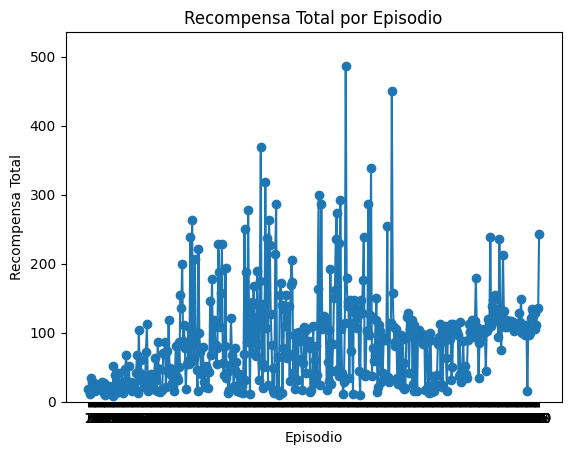

In [7]:
# Environment
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Agent
agent = DQLAgent(state_size, action_size)

# Train agent
train_agent(env, agent)

# Save agent
agent.save("cartpole-dql.h5")

In [ ]:
# Test the model in the environment without rendering
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQLAgent(state_size, action_size)
agent.load("cartpole-dql.h5")

env.close()